In [1]:
pip install h3


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install osmnx


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install folium 


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon

from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats
import datetime
import seaborn as sns
sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.mosaicplot import mosaic
pd.set_option('display.max_columns', 70)

#for heatmap
import folium
import branca
from folium.plugins import HeatMap
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline, Pipeline

In [5]:
df_hex = pd.read_csv('~/__TELE2LAA/spb_hex.csv', sep = ',', decimal = ',', index_col = 0)
df_tracks = pd.read_csv('~/__TELE2LAA/tracks_v2.csv', sep = ';', decimal = ',', index_col = 0)

In [6]:
with open('spb.geojson', "r") as read_file:
    spbjson = json.load(read_file)

### Description of `df_hex`

*   h3_9 - geo mark of a hexagon
*   age_20, age_20_30, age_30_40,	age_40_60,	age_60 - N of people by ages
*   male, female	- N of people by gender, who visited the hexagon
*   car_owners - N of people who owns a car
*   carsharing_user - N of people who used carsharing services in the hexagon
*   not_citizen_rf - N of people who is a foreigner (not a citizen of Russia)
*   public_trnsprt_user	- N of people who uses public transport
*   healthy_food_inter - N of people who eat healthy food
*   salary_1, salary_2, salary_3, salary_4, salary_5 - N of people by salary levels

In [7]:
df_hex.head()

h3_9  age_20  age_20_30  age_30_40  age_40_60  age_60  male  \
0  8911063244fffff       0          0          8          3       1     7   
1  891106074d7ffff       0         13          3          2       1     4   
2  8911062a87bffff       0          0          1          0       0     1   
3  89110615e0fffff       0          2         11         20      15    46   
4  892d721010bffff       0          0          2          1       1     3   

   female  car_owners  carsharing_user  not_citizen_rf  public_trnsprt_user  \
0       5           4                5               2                    0   
1      17          16                1              17                    0   
2       0           1                1               0                    0   
3      19          14                0              22                    1   
4       1           0                0               0                    0   

   healthy_food_inter  salary_1  salary_2  salary_3  salary_4  salary_5  
0                   0         1         6         2         2         1  
1                   0         2         1        14         0         1  
2                   0         0         0         1         0         0  
3                   0        33        12         2         7         4  
4                   0         2         1         0         0         0

### Description of `df_tracks`

*   id - identificator of a person, who visited the area
*   start_dttm - datetime mark for the start of a person's area occupation
*   end_dttm - datetime mark for the end of a person's area occupation
*   h3_9 - geo mark of a hexagon

In [8]:
df_tracks.head() 

id        start_dttm          end_dttm             h3_9
0  9.363030e+11  12.03.2023 23:31  13.03.2023 13:41  891106a1cd3ffff
1  9.363030e+11  13.03.2023 17:04  13.03.2023 20:06  891106a11c3ffff
2  9.363030e+11  08.03.2023 21:25   09.03.2023 9:31  891106a1cd3ffff
3  9.363030e+11   09.03.2023 9:31  09.03.2023 21:38  891106a1cd3ffff
4  9.363030e+11  10.03.2023 21:35  10.03.2023 23:05  891106a11bbffff

In [9]:
df_hex.shape, df_tracks.shape

((32422, 18), (1048575, 4))

In [10]:
df_hex.h3_9.nunique(), df_tracks.h3_9.nunique()

(32422, 30740)

In [11]:
df_hex.describe()

age_20     age_20_30     age_30_40     age_40_60        age_60  \
count  32422.000000  32422.000000  32422.000000  32422.000000  32422.000000   
mean       0.375733      3.841435      9.521128     13.020141      5.028407   
std        3.677471     16.870459     37.079856     49.318395     21.019633   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      1.000000      0.000000   
75%        0.000000      1.000000      2.000000      2.000000      1.000000   
max      154.000000    377.000000    646.000000    720.000000    428.000000   

               male        female    car_owners  carsharing_user  \
count  32422.000000  32422.000000  32422.000000     32422.000000   
mean      19.389519     15.003763     12.067423         4.440596   
std       70.823018     55.956975     45.845068        19.186073   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.000000      0.000000      0.000000         0.000000   
50%        1.000000      1.000000      1.000000         0.000000   
75%        4.000000      3.000000      2.000000         1.000000   
max     1212.000000   1010.000000    749.000000       410.000000   

       not_citizen_rf  public_trnsprt_user  healthy_food_inter      salary_1  \
count    32422.000000         32422.000000        32422.000000  32422.000000   
mean        17.373481             1.036426            0.690395     10.031645   
std         63.602183             6.700514            5.236689     38.792100   
min          0.000000             0.000000            0.000000      0.000000   
25%          0.000000             0.000000            0.000000      0.000000   
50%          1.000000             0.000000            0.000000      0.000000   
75%          4.000000             0.000000            0.000000      2.000000   
max       1025.000000           215.000000          136.000000    618.000000   

           salary_2      salary_3      salary_4      salary_5  
count  32422.000000  32422.000000  32422.000000  32422.000000  
mean       6.140121      4.678521      3.623527      3.015514  
std       25.283005     20.009757     16.111299     14.189090  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000  
75%        1.000000      1.000000      1.000000      0.000000  
max      490.000000    363.000000    311.000000    317.000000

In [12]:
df_tracks.describe()

id
count  1.048575e+06
mean   8.566023e+11
std    5.008047e+11
min    0.000000e+00
25%    4.209070e+11
50%    8.504040e+11
75%    1.288490e+12
max    1.726580e+12

In [13]:
(df_hex.isna().sum() / len(df_hex)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

In [14]:
(df_tracks.isna().sum() / len(df_hex)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

In [15]:
df_hex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32422 entries, 0 to 32421
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   h3_9                 32422 non-null  object
 1   age_20               32422 non-null  int64 
 2   age_20_30            32422 non-null  int64 
 3   age_30_40            32422 non-null  int64 
 4   age_40_60            32422 non-null  int64 
 5   age_60               32422 non-null  int64 
 6   male                 32422 non-null  int64 
 7   female               32422 non-null  int64 
 8   car_owners           32422 non-null  int64 
 9   carsharing_user      32422 non-null  int64 
 10  not_citizen_rf       32422 non-null  int64 
 11  public_trnsprt_user  32422 non-null  int64 
 12  healthy_food_inter   32422 non-null  int64 
 13  salary_1             32422 non-null  int64 
 14  salary_2             32422 non-null  int64 
 15  salary_3             32422 non-null  int64 
 16  sala

In [16]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1048575 non-null  float64
 1   start_dttm  1048575 non-null  object 
 2   end_dttm    1048575 non-null  object 
 3   h3_9        1048575 non-null  object 
dtypes: float64(1), object(3)
memory usage: 40.0+ MB


### Processing of `df_tracks`

In [17]:
# convert data format of df_tracks and extract duration, days, time and minutes
df_tracks['start_dttm'] = pd.to_datetime(df_tracks['start_dttm'], format='%d.%m.%Y %H:%M')
df_tracks['end_dttm'] = pd.to_datetime(df_tracks['end_dttm'], format='%d.%m.%Y %H:%M')

df_tracks['duration'] = df_tracks.end_dttm - df_tracks.start_dttm

df_tracks['days'] = df_tracks['duration'].dt.days
df_tracks['time'] = pd.to_timedelta(df_tracks['duration']).dt.components['hours'].astype(str) + ':' + \
             pd.to_timedelta(df_tracks['duration']).dt.components['minutes'].astype(str) + ':' + \
             pd.to_timedelta(df_tracks['duration']).dt.components['seconds'].astype(str)
df_tracks['hours'] =  pd.to_timedelta(df_tracks['duration']).dt.components['hours'].astype(int)
df_tracks['minutes'] =  pd.to_timedelta(df_tracks['duration']).dt.components['minutes'].astype(int)

# remove rows with negative duration of a stay
df_tracks = df_tracks.drop(df_tracks[df_tracks['days'] < 0].index)

In [18]:
df_tracks.head()

id          start_dttm            end_dttm             h3_9  \
0  9.363030e+11 2023-03-12 23:31:00 2023-03-13 13:41:00  891106a1cd3ffff   
1  9.363030e+11 2023-03-13 17:04:00 2023-03-13 20:06:00  891106a11c3ffff   
2  9.363030e+11 2023-03-08 21:25:00 2023-03-09 09:31:00  891106a1cd3ffff   
3  9.363030e+11 2023-03-09 09:31:00 2023-03-09 21:38:00  891106a1cd3ffff   
4  9.363030e+11 2023-03-10 21:35:00 2023-03-10 23:05:00  891106a11bbffff   

         duration  days     time  hours  minutes  
0 0 days 14:10:00     0  14:10:0     14       10  
1 0 days 03:02:00     0    3:2:0      3        2  
2 0 days 12:06:00     0   12:6:0     12        6  
3 0 days 12:07:00     0   12:7:0     12        7  
4 0 days 01:30:00     0   1:30:0      1       30

In [19]:
# check for duration more than a month
p,q = df_tracks[df_tracks['days'] > 30].shape
print("N of cases with duration more than a month:", p, " out of ", len(df_tracks))

N of cases with duration more than a month: 0  out of  1034399


In [20]:
# get N of cases where end date is less than start date
k,z = df_tracks[df_tracks['end_dttm'] < df_tracks['start_dttm']].shape
print("N of invalid cases of stay:", k, " out of ", len(df_tracks))
print("Percentage of invalid cases:", round(k/len(df_tracks) * 100,2), '%')

N of invalid cases of stay: 0  out of  1034399
Percentage of invalid cases: 0.0 %


In [21]:
# to check the previous step: get N of cases with negative duration of a stay
x,y = df_tracks[df_tracks['days'] < 0].shape
print("N of cases with negative duration:", x, " out of ", len(df_tracks))
print("Percentage of rows with negative duration:", round(x/len(df_tracks) * 100,2), '%')

N of cases with negative duration: 0  out of  1034399
Percentage of rows with negative duration: 0.0 %


In [22]:
# remove rows with negative duration of a stay
df_tracks = df_tracks.drop(df_tracks[df_tracks['days'] < 0].index)

In [23]:
df_tracks.head() 

id          start_dttm            end_dttm             h3_9  \
0  9.363030e+11 2023-03-12 23:31:00 2023-03-13 13:41:00  891106a1cd3ffff   
1  9.363030e+11 2023-03-13 17:04:00 2023-03-13 20:06:00  891106a11c3ffff   
2  9.363030e+11 2023-03-08 21:25:00 2023-03-09 09:31:00  891106a1cd3ffff   
3  9.363030e+11 2023-03-09 09:31:00 2023-03-09 21:38:00  891106a1cd3ffff   
4  9.363030e+11 2023-03-10 21:35:00 2023-03-10 23:05:00  891106a11bbffff   

         duration  days     time  hours  minutes  
0 0 days 14:10:00     0  14:10:0     14       10  
1 0 days 03:02:00     0    3:2:0      3        2  
2 0 days 12:06:00     0   12:6:0     12        6  
3 0 days 12:07:00     0   12:7:0     12        7  
4 0 days 01:30:00     0   1:30:0      1       30

### Processing of `df_hex`

In [24]:
# people's count check
df_hex_age_count = df_hex.iloc[:, :6].sum(axis=1)     # age_count - sum of people of all ages (20, 20&30, 30&40, 40&60, 60) for a df_hex
df_hex_gender_count = df_hex.iloc[:, 6:8].sum(axis=1) # gender_count - sum of people of all genders
df_hex_salary_count = df_hex.iloc[:, -5:].sum(axis=1) # salary_count - sum of people of all salaries
df_groupped_hex = pd.DataFrame({'age_count': df_hex_age_count, 'gender_count': df_hex_gender_count, 'salary_count': df_hex_salary_count})
df_groupped_hex.insert(loc=0, column='h3_9', value=df_hex.h3_9)
df_groupped_hex[['car_owners', 'carsharing_user', 'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter']] = df_hex[['car_owners', 'carsharing_user', 'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter']]
df_groupped_hex.head()

h3_9  age_count  gender_count  salary_count  car_owners  \
0  8911063244fffff         12            12            12           4   
1  891106074d7ffff         19            21            18          16   
2  8911062a87bffff          1             1             1           1   
3  89110615e0fffff         48            65            58          14   
4  892d721010bffff          4             4             3           0   

   carsharing_user  not_citizen_rf  public_trnsprt_user  healthy_food_inter  
0                5               2                    0                   0  
1                1              17                    0                   0  
2                1               0                    0                   0  
3                0              22                    1                   0  
4                0               0                    0                   0

In [25]:
# get N of cases where age_count is not equal to gender count
t,l = df_groupped_hex[df_groupped_hex['age_count'] != df_groupped_hex['gender_count']].shape
print("N of cases where age_count is not equal to gender count:", t, " out of ", len(df_groupped_hex))
print("Percentage of rows with uneven N:", round(t/len(df_groupped_hex) * 100,2), '%')
#вопрос - что делаем с ними?

N of cases where age_count is not equal to gender count: 6643  out of  32422
Percentage of rows with uneven N: 20.49 %


### Visualization 

<AxesSubplot: >

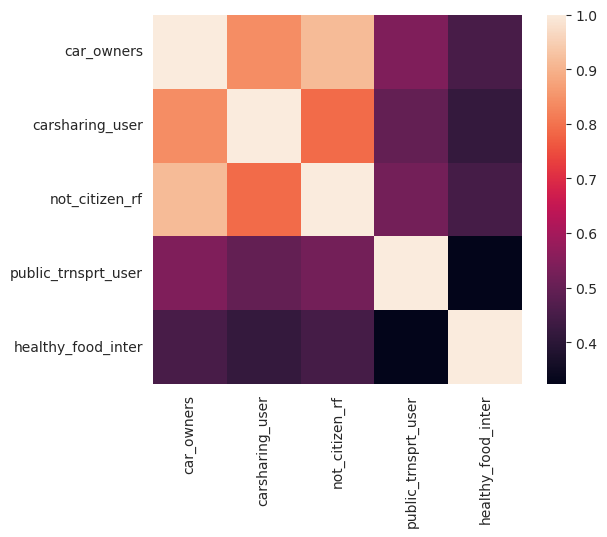

In [26]:
df_groupped_hex1 = df_groupped_hex[['car_owners', 'carsharing_user', 'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter']] #Subsetting the data
cor = df_groupped_hex1.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

The lighter shade represents high correlation. We can see that car_owners score is highly correlated with car_sharing_user and not_citizen_rf. It is least correlated with healthy_food_inter.

#### Distribution of duration of a stay

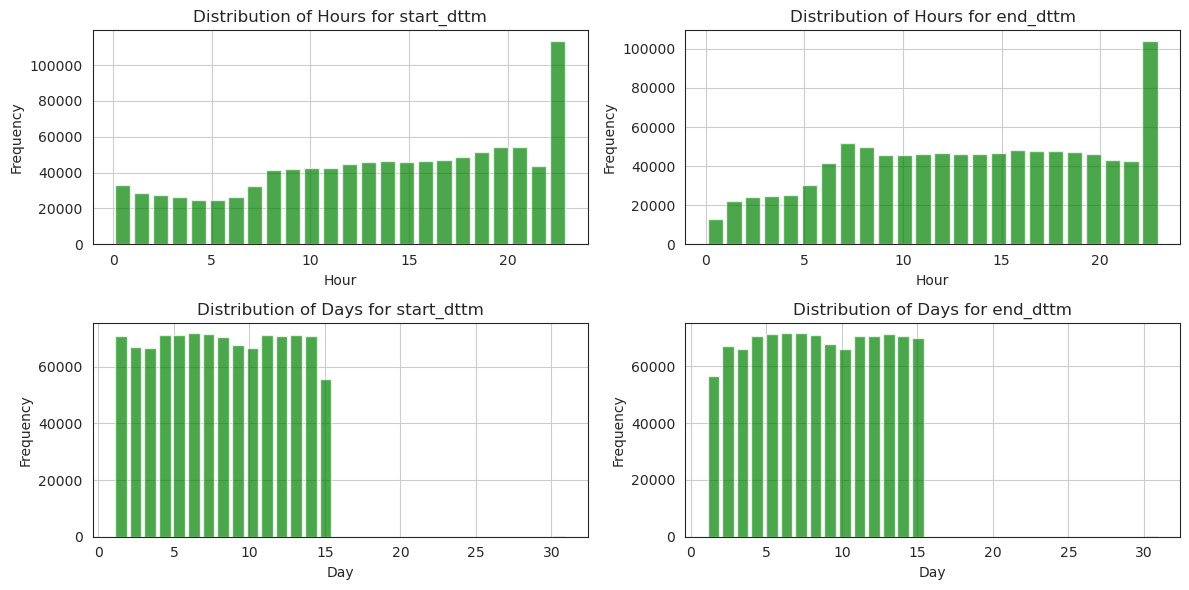

In [27]:
df_tracks['start_dttm_hour'] = df_tracks['start_dttm'].dt.hour
df_tracks['end_dttm_hour'] = df_tracks['end_dttm'].dt.hour

df_tracks['start_dttm_day'] = df_tracks['start_dttm'].dt.day
df_tracks['end_dttm_day'] = df_tracks['end_dttm'].dt.day

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
df_tracks['start_dttm_hour'].hist(bins=24, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Hours for start_dttm')
plt.xlabel('Hour')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
df_tracks['end_dttm_hour'].hist(bins=24, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Hours for end_dttm')
plt.xlabel('Hour')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
df_tracks['start_dttm_day'].hist(bins=31, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Days for start_dttm')
plt.xlabel('Day')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
df_tracks['end_dttm_day'].hist(bins=31, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Days for end_dttm')
plt.xlabel('Day')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
df_tracks['start_dttm_hour'].value_counts(normalize = True).head(10)

23    0.109940
21    0.052408
20    0.052345
19    0.049989
18    0.047191
17    0.045519
14    0.045044
16    0.044775
13    0.044302
15    0.044187
Name: start_dttm_hour, dtype: float64

In [29]:
df_tracks['duration_hours'] = round((df_tracks['end_dttm'] - df_tracks['start_dttm']).dt.total_seconds() / 3600, 2)  # Convert to hours

In [30]:
df_tracks['duration_hours'].value_counts(normalize = True).head(20)

1.00    0.092042
2.00    0.026909
1.50    0.019180
1.02    0.011892
3.00    0.011375
1.03    0.010575
1.05    0.009914
1.07    0.009407
1.08    0.008997
1.10    0.008953
2.50    0.008876
1.12    0.008695
1.13    0.008445
1.15    0.008158
4.00    0.008029
1.17    0.007940
1.18    0.007931
1.20    0.007511
1.22    0.007258
1.23    0.007198
Name: duration_hours, dtype: float64

#### Most popular hexes

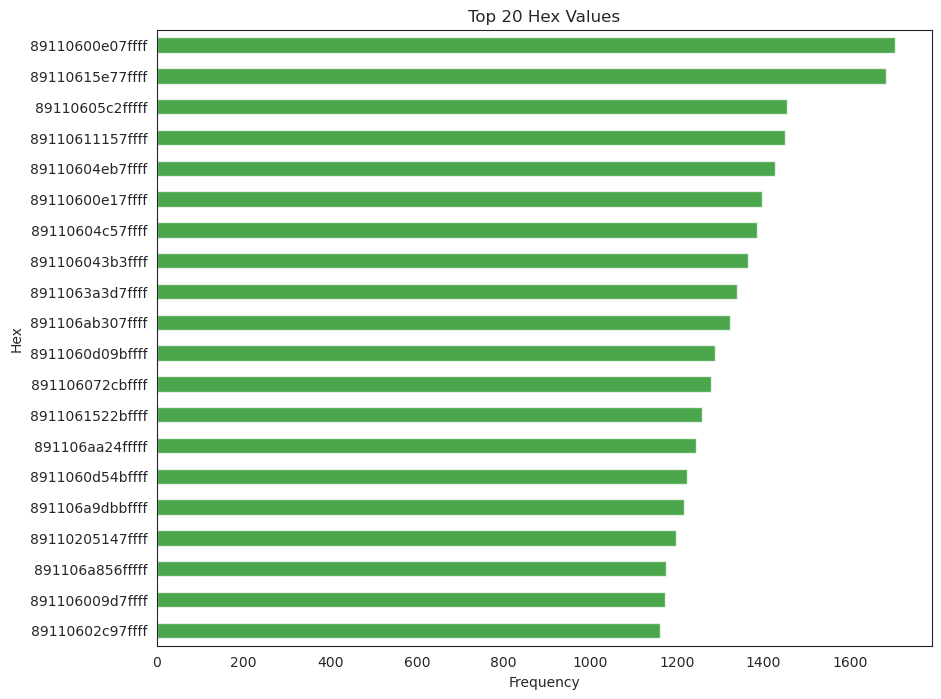

In [31]:
h3_9_counts = df_tracks['h3_9'].value_counts()
top_20_h3_9 = h3_9_counts.head(20)

plt.figure(figsize=(10, 8))
top_20_h3_9.sort_values().plot(kind='barh', color='green', alpha=0.7)
plt.title('Top 20 Hex Values')
plt.xlabel('Frequency')
plt.ylabel('Hex')

plt.show()

#### Ages distrubution

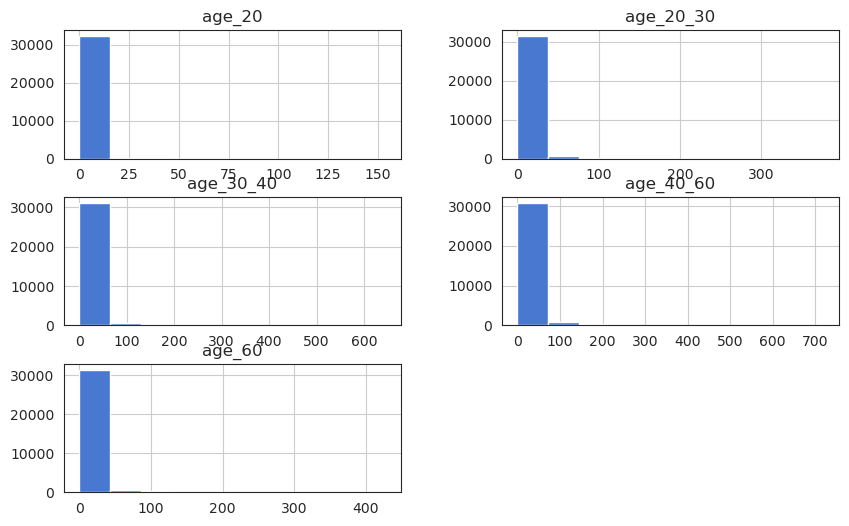

In [32]:
histograms = df_hex.iloc[:,:6].hist(figsize=(10,6))

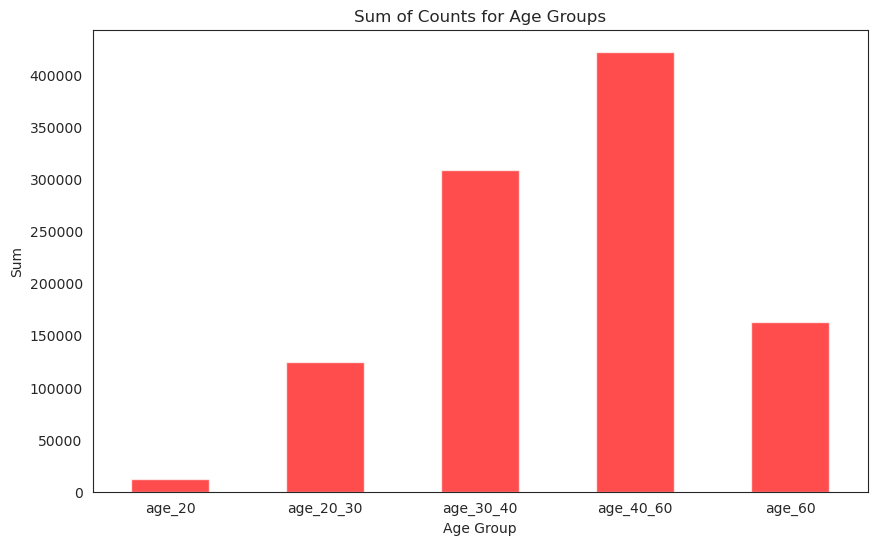

In [33]:
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

age_sums = df_hex[age_columns].sum()

plt.figure(figsize=(10, 6))
age_sums.plot(kind='bar', color='red', alpha=0.7)
plt.title('Sum of Counts for Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Sum')
plt.xticks(rotation=0)

plt.show()

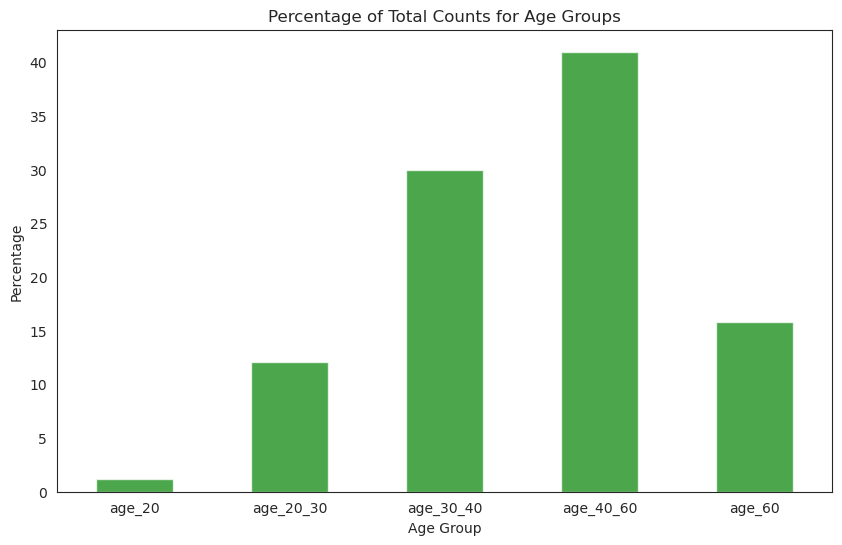

In [34]:
age_percentages = df_hex[age_columns].sum() / df_hex[age_columns].sum().sum() * 100

plt.figure(figsize=(10, 6))
age_percentages.plot(kind='bar', color='green', alpha=0.7)
plt.title('Percentage of Total Counts for Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

plt.show()

#### Salaries distribution

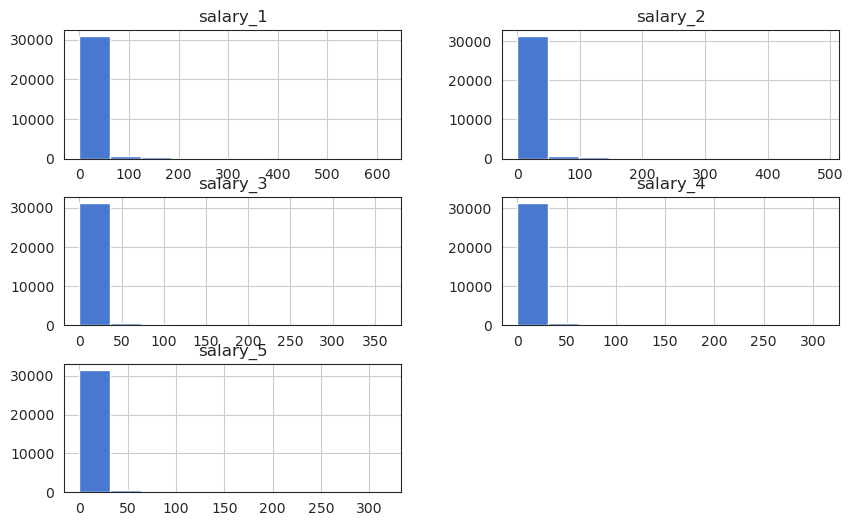

In [35]:
histograms = df_hex.iloc[:, -5:].hist(figsize=(10,6))

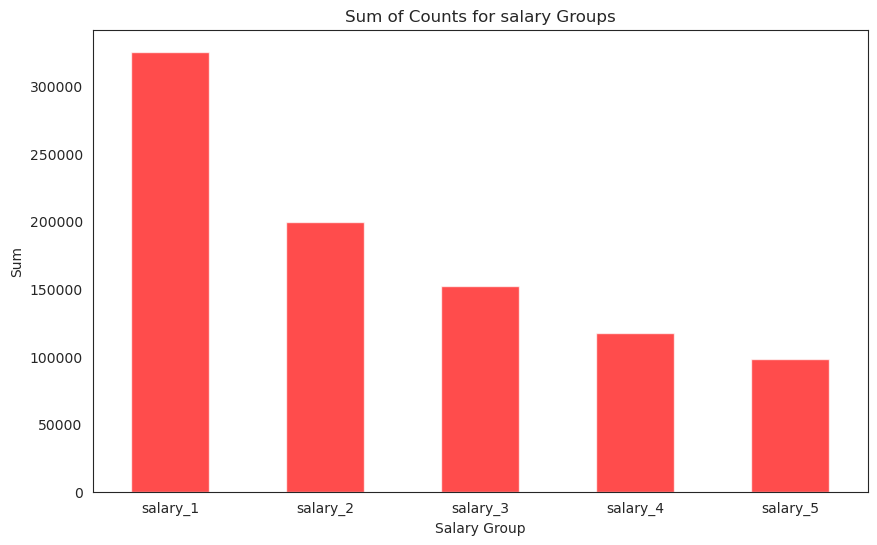

In [36]:
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5' ]

salary_sums = df_hex[salary_columns].sum()

plt.figure(figsize=(10, 6))
salary_sums.plot(kind='bar', color='red', alpha=0.7)
plt.title('Sum of Counts for salary Groups')
plt.xlabel('Salary Group')
plt.ylabel('Sum')
plt.xticks(rotation=0)

plt.show()

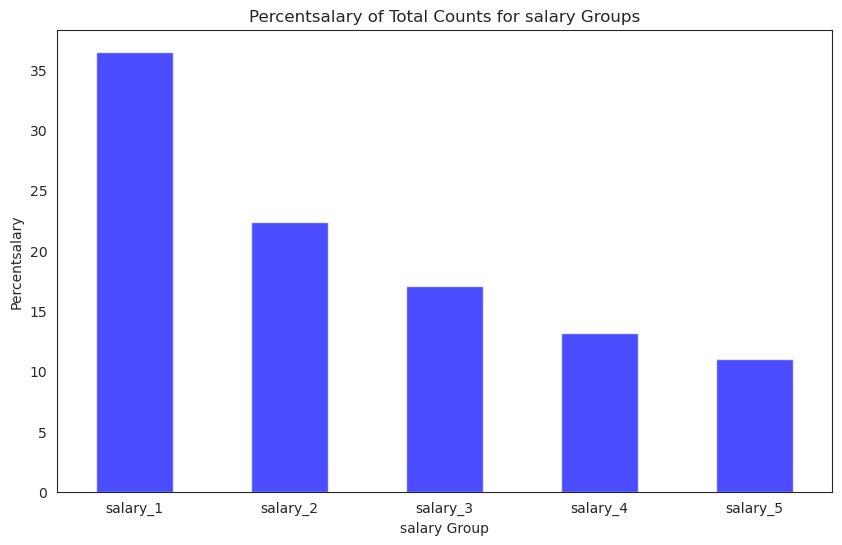

In [37]:
salary_percentsalarys = df_hex[salary_columns].sum() / df_hex[salary_columns].sum().sum() * 100

plt.figure(figsize=(10, 6))
salary_percentsalarys.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Percentsalary of Total Counts for salary Groups')
plt.xlabel('salary Group')
plt.ylabel('Percentsalary')
plt.xticks(rotation=0)

plt.show()

#### Gender distribution

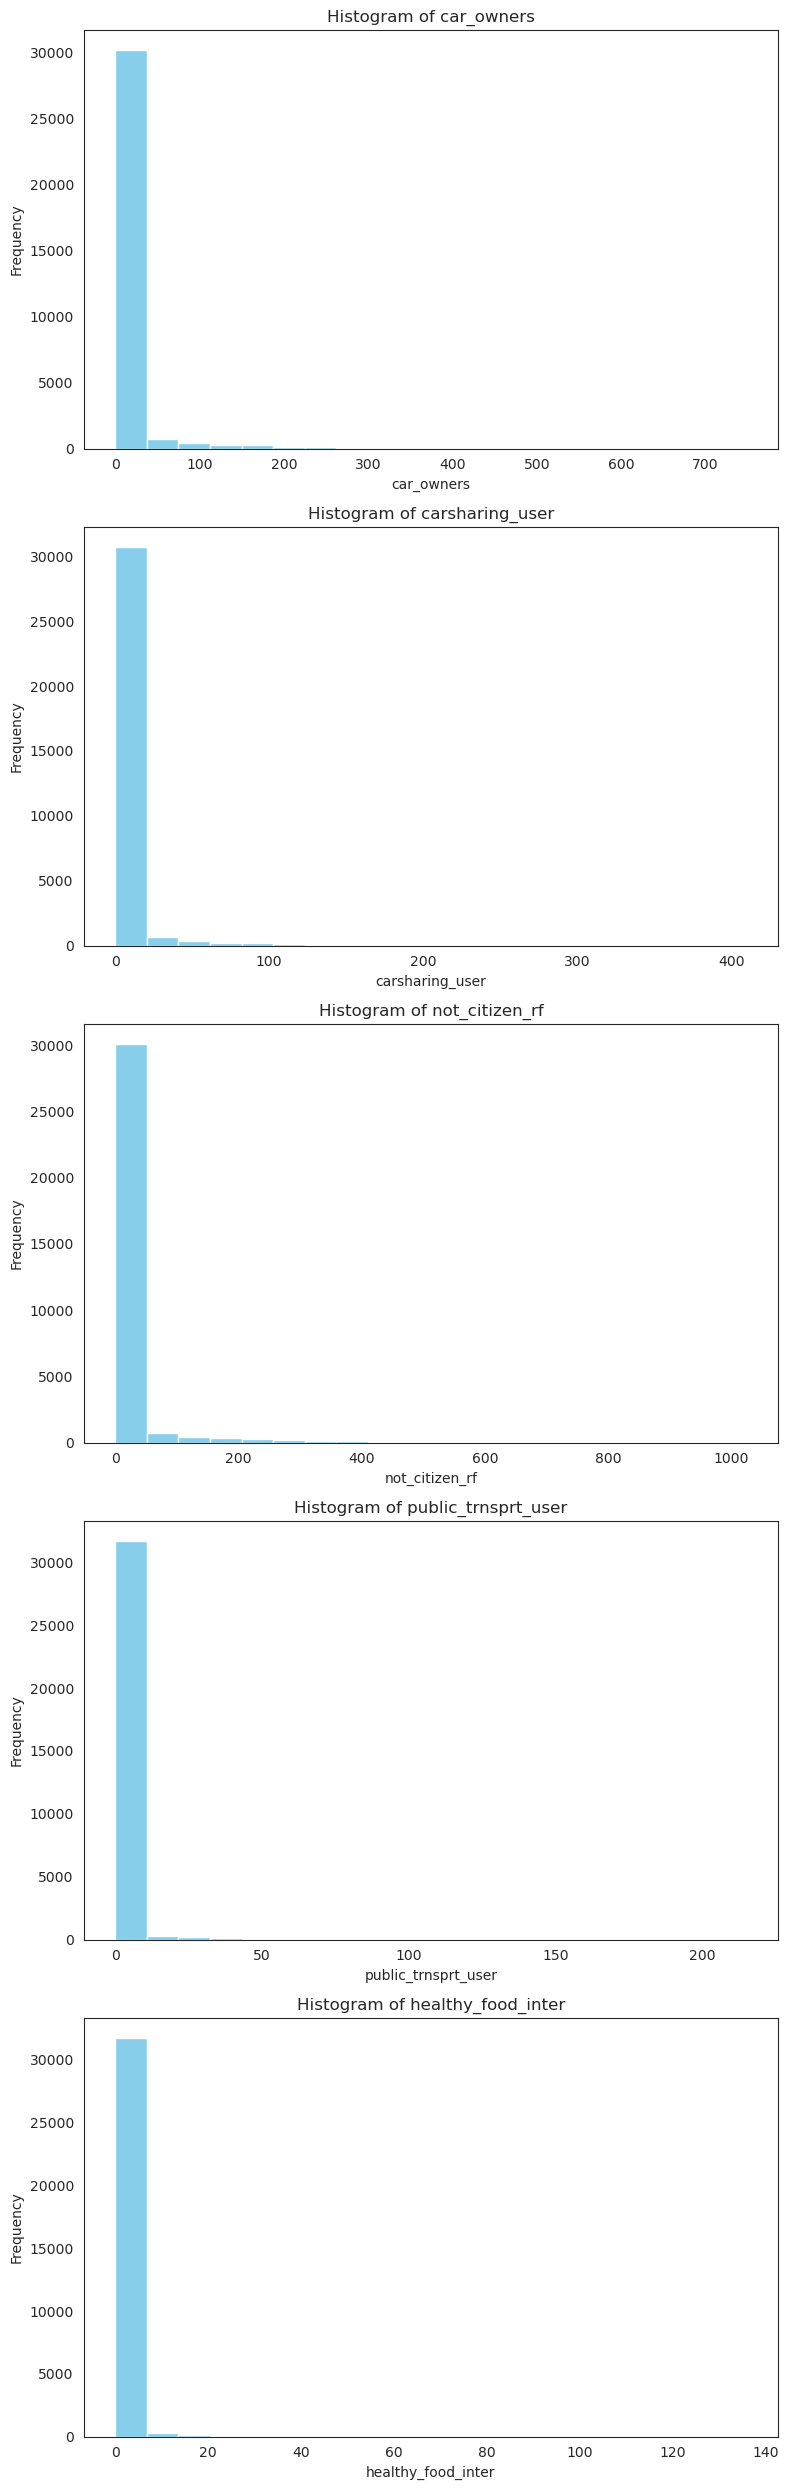

In [38]:
visualization_columns = ['car_owners', 'carsharing_user', 'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter']

fig, axes = plt.subplots(nrows=len(visualization_columns), ncols=1, figsize=(8, 5 * len(visualization_columns)))

for i, column in enumerate(visualization_columns):
    axes[i].hist(df_hex[column], bins=20, color='skyblue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Hex Mesh

In [39]:
# SPb boarder
def visualize_polygons(geometry):

    lats, lons = get_lat_lon(geometry)

    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=10, tiles='cartodbpositron')

    overlay = gpd.GeoSeries(geometry).to_json()
    folium.GeoJson(overlay, name = 'boundary').add_to(m)

    return m

def get_lat_lon(geometry):

    lon = geometry.apply(lambda x: x.x if x.geom_type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.geom_type == 'Point' else x.centroid.y)
    return lat, lon

cities = ['Санкт-Петербург']
polygon_spb = ox.features_from_place(cities, {'boundary':'administrative'}).reset_index()
polygon_spb = polygon_spb[(polygon_spb['name'] == 'Санкт-Петербург')]
polygon_spb['geometry']

#visualize_polygons(polygon_spb['geometry'])

1151    MULTIPOLYGON (((30.06506 59.66830, 30.07331 59...
Name: geometry, dtype: geometry

In [40]:
def create_hexagons(geoJson, resolution):

    polyline = geoJson['coordinates'][0]

    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
    m.add_child(my_PolyLine)

    hexagons = list(h3.polyfill(geoJson, resolution))
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=3,color='red')
        m.add_child(my_PolyLine)

    polylines_x = []
    for j in range(len(polylines)):
        a = np.column_stack((np.array(polylines[j])[:,1],np.array(polylines[j])[:,0])).tolist()
        polylines_x.append([(a[i][0], a[i][1]) for i in range(len(a))])

    polygons_hex = pd.Series(polylines_x).apply(lambda x: Polygon(x))

    return m, polygons_hex, polylines

#### Compare hex mesh representation from Open Street Map (OSM) and spb.geojson

In [43]:
#data from OSM
# generate hexes of SPb from OSM
geoJson = json.loads(gpd.GeoSeries(polygon_spb['geometry']).to_json())
geoJson = geoJson['features'][0]['geometry']

# take main area for OSM and imported geojson
geoJson = {'type':'Polygon','coordinates': [np.column_stack((np.array(geoJson['coordinates'][1])[:, :, 1][0],
                                                      np.array(geoJson['coordinates'][1])[:,:, 0][0])).tolist()]}

spbjson = {'type':'Polygon','coordinates': [np.column_stack((np.array(spbjson['coordinates'][0])[:, 1],
                                                      np.array(spbjson['coordinates'][0])[:, 0])).tolist()]}

# visualize poligons from OSM
m, polygons, polylines = create_hexagons(geoJson, 6)
m

In [45]:
#data from spb.geojson

m, polygons, polylines = create_hexagons(spbjson, 6)
m
#https://map.openseamap.org/  map with coordinates, we need coordinated in range 59-60 (широта - latitude), 29-30 (долгота - longitude)

#### Get additional data on certain categories from OSM for each hex

In [48]:
def osm_query(tag, city):
    gdf = ox.features_from_place(city, tag).reset_index()
    gdf['city'] = np.full(len(gdf), city.split(',')[0])
    gdf['object'] = np.full(len(gdf), list(tag.keys())[0])
    gdf['type'] = np.full(len(gdf), tag[list(tag.keys())[0]])
    gdf = gdf[['city', 'object', 'type', 'geometry']]
    print(gdf.shape)
    return gdf

# Get objects to show on a map in hexes
tags = [
        {'building' : 'apartments'}, {'building' : 'detached'},
        {'building' : 'dormitory'}, {'building' : 'hotel'},
        {'building' : 'house'}, {'building' : 'semidetached_house'},
        {'building' : 'terrace'},  {'building' : 'commercial'},
        {'building' : 'office'},  {'building' : 'terrace'},
        {'building' : 'terrace'}, {'building':'retail'},
        {'building':'train_station'},
        {'highway' : 'bus_stop'}, {'footway':'crossing'},
        {'amenity':'cafe'}, {'amenity':'fast_food'},
        {'amenity':'restaurant'}, {'amenity':'college'},
        {'amenity':'language_school'},  {'amenity':'school'},
        {'amenity':'university'},  {'amenity':'atm'},
        {'amenity':'bank'},  {'amenity':'clinic'},
        {'amenity':'hospital'},  {'amenity':'pharmacy'},
        {'amenity':'theatre'},  {'amenity':'townhall'},
        {'amenity':'bench'},
       ]

cities = ['Санкт-Петербург, Россия']

gdfs = []
for city in cities:
    for tag in tags:
        gdfs.append(osm_query(tag, city))

data_poi = pd.concat(gdfs)
data_poi.groupby(['city','object','type'], as_index = False).agg({'geometry':'count'})

# add coordinates and centroids
lat, lon = get_lat_lon(data_poi['geometry'])
data_poi['lat'] = lat
data_poi['lon'] = lon

(18777, 4)
(2761, 4)
(537, 4)
(134, 4)
(5802, 4)
(29, 4)
(275, 4)
(515, 4)
(1169, 4)
(275, 4)
(275, 4)
(1377, 4)
(89, 4)
(5627, 4)
(11030, 4)
(3316, 4)
(2692, 4)
(1397, 4)
(187, 4)
(105, 4)
(963, 4)
(249, 4)
(2064, 4)
(948, 4)
(541, 4)
(151, 4)
(2060, 4)
(129, 4)
(51, 4)
(19548, 4)


In [49]:
# join objects and hexs
gdf_1 = gpd.GeoDataFrame(data_poi, geometry=gpd.points_from_xy(data_poi.lon, data_poi.lat))

gdf_2 = pd.DataFrame(polygons, columns = ['geometry'])
gdf_2['polylines'] = polylines
gdf_2['geometry'] = gdf_2['geometry'].astype(str)
geometry_uniq = pd.DataFrame(gdf_2['geometry'].drop_duplicates())
geometry_uniq['id'] = np.arange(len(geometry_uniq)).astype(str)
gdf_2 = gdf_2.merge(geometry_uniq, on = 'geometry')
gdf_2['geometry'] = gdf_2['geometry'].apply(wkt.loads)
gdf_2 = gpd.GeoDataFrame(gdf_2, geometry='geometry')

itog_table = gpd.sjoin(gdf_2, gdf_1, how='left', predicate='intersects')
itog_table = itog_table.dropna()
itog_table.head()

/tmp/ipykernel_218/3247819368.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  itog_table = gpd.sjoin(gdf_2, gdf_1, how='left', predicate='intersects')


geometry  \
36  POLYGON ((30.23174 59.66374, 30.28819 59.67097...   
36  POLYGON ((30.23174 59.66374, 30.28819 59.67097...   
36  POLYGON ((30.23174 59.66374, 30.28819 59.67097...   
36  POLYGON ((30.23174 59.66374, 30.28819 59.67097...   
36  POLYGON ((30.23174 59.66374, 30.28819 59.67097...   

                                            polylines  id  index_right  \
36  [(59.66374478330571, 30.231735765020538), (59....  36       7470.0   
36  [(59.66374478330571, 30.231735765020538), (59....  36       7471.0   
36  [(59.66374478330571, 30.231735765020538), (59....  36       7454.0   
36  [(59.66374478330571, 30.231735765020538), (59....  36       7472.0   
36  [(59.66374478330571, 30.231735765020538), (59....  36       7452.0   

               city    object        type        lat        lon  
36  Санкт-Петербург  building  apartments  59.667461  30.256025  
36  Санкт-Петербург  building  apartments  59.668453  30.256386  
36  Санкт-Петербург  building  apartments  59.668768  30.257668  
36  Санкт-Петербург  building  apartments  59.669440  30.258211  
36  Санкт-Петербург  building  apartments  59.668328  30.260373

In [50]:
def create_choropleth(category_type, columns, legend_name, feature, bins):

    itog_table['geometry'] = itog_table['geometry'].astype(str)
    itog_table['id'] = itog_table['id'].astype(str)
    agg_all = itog_table.groupby(['geometry','type','id'], as_index = False).agg({'lat':'count'}).rename(columns = {'lat':'counts'})
    agg_all['geometry'] = agg_all['geometry'].apply(wkt.loads)

    data = agg_all.query(f"type == '{category_type}'")[["geometry","counts",'id']]
    data['id'] = data['id'].astype(str)
    json = gpd.GeoSeries(data.set_index('id')["geometry"]).to_json()

    lat, lon = get_lat_lon(data['geometry'])

    m = folium.Map(location=[sum(lat)/len(lat), sum(lon)/len(lon)], zoom_start=10, tiles='cartodbpositron')

    folium.Choropleth(
        geo_data=json,
        name="choropleth",
        data=data,
        columns=columns,
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        nan_fill_color = 'black',
        bins = bins

    ).add_to(m)

    folium.LayerControl().add_to(m)

    return m

#choose what to show on a map
category_type = 'atm'
#'apartments', 'detached', 'dormitory', 'hotel', 'house', 'semidetached_house', 'terrace', 'commercial', 'retail', 'train_station'
#'bus_stop', 'crossing', 'cafe', 'fast_food', 'restaurant', 'college', 'language_school','school', 'university', 'atm'
#'bank', 'clinic', 'pharmacy', 'hospital', 'theatre', 'townhall', 'bench'

create_choropleth(category_type, ["id","counts"], f'{category_type} counts', 'counts', 20)

/tmp/ipykernel_218/2048177013.py:3: UserWarning: Geometry column does not contain geometry.
  itog_table['geometry'] = itog_table['geometry'].astype(str)


In [51]:
gdf_aparts = ox.geometries_from_place(city, {'building' : 'apartments'}).reset_index()
# полнота building:levels (этажи)
print(np.round(len(gdf_aparts['building:levels'].dropna())/len(gdf_aparts['building:levels']), 2))

# полнота building:flats (квартиры)
print(np.round(len(gdf_aparts['building:flats'].dropna())/len(gdf_aparts['building:flats']), 2))

/tmp/ipykernel_218/1885124262.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf_aparts = ox.geometries_from_place(city, {'building' : 'apartments'}).reset_index()


0.96
0.17


In [52]:
gdf_aparts.head(3)

element_type     osmid addr:flats  ref  \
0          way  17558293        NaN  NaN   
1          way  17558615        NaN  NaN   
2          way  17558755        NaN  NaN   

                                            geometry        addr:city  \
0  POLYGON ((30.22784 59.94241, 30.22778 59.94240...  Санкт-Петербург   
1  POLYGON ((30.22853 59.94347, 30.22905 59.94339...  Санкт-Петербург   
2  POLYGON ((30.22590 59.94306, 30.22591 59.94305...  Санкт-Петербург   

  addr:country addr:housenumber     addr:street wheelchair amenity  \
0           RU             3 к1  улица Нахимова        NaN     NaN   
1           RU               30  Наличная улица        NaN     NaN   
2           RU             3 к3  улица Нахимова        NaN     NaN   

  design:year operator name shop name:uk check_date brand contact:vk  \
0         NaN      NaN  NaN  NaN     NaN        NaN   NaN        NaN   
1         NaN      NaN  NaN  NaN     NaN        NaN   NaN        NaN   
2         NaN      NaN  NaN  NaN     NaN        NaN   NaN        NaN   

  opening_hours payment:cash payment:maestro payment:mastercard payment:visa  \
0           NaN          NaN             NaN                NaN          NaN   
1           NaN          NaN             NaN                NaN          NaN   
2           NaN          NaN             NaN                NaN          NaN   

  payment:visa_electron website note description office phone fixme  \
0                   NaN     NaN  NaN         NaN    NaN   NaN   NaN   
1                   NaN     NaN  NaN         NaN    NaN   NaN   NaN   
2                   NaN     NaN  NaN         NaN    NaN   NaN   NaN   

  contact:phone contact:website level historic  ... number_of_apartments ways  \
0           NaN             NaN   NaN      NaN  ...                  NaN  NaN   
1           NaN             NaN   NaN      NaN  ...                  NaN  NaN   
2           NaN             NaN   NaN      NaN  ...                  NaN  NaN   

  addr:street2 heritage addr:housenumber2 note_2 postal_code heritage:website  \
0          NaN      NaN               NaN    NaN         NaN              NaN   
1          NaN      NaN               NaN    NaN         NaN              NaN   
2          NaN      NaN               NaN    NaN         NaN              NaN   

   url was:name source:flats building:flats:note year_built  \
0  NaN      NaN          NaN                 NaN        NaN   
1  NaN      NaN          NaN                 NaN        NaN   
2  NaN      NaN          NaN                 NaN        NaN   

  addr:housenumber:RGis addr:full building:part:use source2 roof:shape:eaves  \
0                   NaN       NaN               NaN     NaN              NaN   
1                   NaN       NaN               NaN     NaN              NaN   
2                   NaN       NaN               NaN     NaN              NaN   

  nohousenumber proposed:building:flats heating maintained operator:website  \
0           NaN                     NaN     NaN        NaN              NaN   
1           NaN                     NaN     NaN        NaN              NaN   
2           NaN                     NaN     NaN        NaN              NaN   

  phone:mobile source_ref official_short_type addr:source notes  \
0          NaN        NaN                 NaN         NaN   NaN   
1          NaN        NaN                 NaN         NaN   NaN   
2          NaN        NaN                 NaN         NaN   NaN   

  construction:addr:housenumber building:facade:color min_height  \
0                           NaN                   NaN        NaN   
1                           NaN                   NaN        NaN   
2                           NaN                   NaN        NaN   

  design:framework roof:direction source:website attraction  
0              NaN            NaN            NaN        NaN  
1              NaN            NaN            NaN        NaN  
2              NaN            NaN            NaN        NaN  

[3 rows x 178 columns]

In [53]:
from shapely.wkt import loads
itog_table.geometry =  itog_table['geometry'].apply(loads)

In [54]:
lat_g, lon_g = get_lat_lon(gdf_aparts['geometry'])
gdf_aparts['lat'] = lat_g
gdf_aparts['lon'] = lon_g

itog_table_people = itog_table.merge(gdf_aparts[['lat', 'lon', 'building:levels']], on = ['lat', 'lon'], how = 'left')
itog_table_people['building:levels'] = itog_table_people['building:levels'].fillna(1)
itog_table_people = itog_table_people.rename(columns = {'building:levels' : 'levels'})

apartments = ['apartments' , 'dormitory']
houses = ['house', 'semidetached_house', 'detached', 'terrace']
people_ctn = []

# в среднем возьмем 3 чел. на семью

for i in range(len(itog_table_people)):
    if itog_table_people['type'].iloc[i] in apartments:
        level_value = itog_table_people['levels'].iloc[i]
        if isinstance(level_value, int):
            people = int(level_value) * 10 * 3
        elif isinstance(level_value, float):
            people = int(level_value) * 10 * 3
        else:
            people = 'not living area'
    elif itog_table_people['type'].iloc[i] in houses:
        level_value = itog_table_people['levels'].iloc[i]
        if isinstance(level_value, int):
            people = int(level_value) * 3
        elif isinstance(level_value, float):
            people = int(level_value) * 3
        else:
            people = 'not living area'
    else:
        people = 'not living area'
    people_ctn.append(people)

itog_table_people['count_people'] = people_ctn

table_people = itog_table_people.query("count_people != 'not living area'")
table_people['count_people'] = table_people['count_people'].astype(int)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [55]:
def create_heatmap(data, lat_lon_feature):
    m = folium.Map(location=[data['lat'].mean(), data['lon'].mean()], zoom_start=13, tiles='cartodbpositron')

    heat_data = data[lat_lon_feature].groupby(lat_lon_feature[0:2]).sum().reset_index().values.tolist()
    max_val = int(data[lat_lon_feature[2]].quantile(0.75))

    HeatMap(heat_data, radius=70, min_opacity=0.05, max_val=max_val, blur=30).add_to(m)

    colormap = branca.colormap.LinearColormap(colors=['blue', 'green', 'yellow', 'red'], vmin=0, vmax=max_val)
    colormap.caption = 'Population Density'
    colormap.add_to(m)

    return m

# population density map
create_heatmap(table_people, ['lat', 'lon', 'count_people'])

/tmp/ipykernel_218/930117606.py:7: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data, radius=70, min_opacity=0.05, max_val=max_val, blur=30).add_to(m)
